# Script to produce Fig. 6

## Load packages

In [2]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy as crt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings('ignore')

## Settings and folder paths

In [3]:
plt.style.use("seaborn-v0_8")
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=3.5)

idir = r'C:\Users\muis\OneDrive - Stichting Deltares\Desktop\paper_gtsmip\data'

models = ['EC-Earth3P-HR','HadGEM3-GC31-HM-SST','GFDL-CM4C192-SST','CMCC-CM2-VHR4','HadGEM3-GC31-HM']
rp = 10
periods = ['1951-1980','1985-2014','2021-2050']

## Load data and store in single DataFrame 

In [4]:
# bedlevel
ifile = 'data/bedlevel.nc'
ds_bedlevel = xr.open_dataset(ifile)
pxyn = ds_bedlevel.to_dataframe()

# HighResMIP
df_models = []
for model, period in itertools.product(models, periods):   
    sim = 'future' if period == '2021-2050' else 'historical'
    nc_file = os.path.join(idir,'%s_%s_surge_actual-value_%s_rp%s_best-fit_v1.nc' % (str(model),str(sim),str(period),str(rp)))    
    ds_model = xr.open_dataset(nc_file)
    df_model = ds_model['return_mean_surge_level'].to_dataframe()
    df_model.rename(columns={df_model.columns[2]: '%s_%s' % (model,period)}, inplace = True)
    df_model.drop(columns=['station_x_coordinate','station_y_coordinate'],inplace=True)
    df_models.append(df_model)
df_data = pd.concat(df_models, axis=1)


## Compute changes

In [6]:
# ensemble stats
df_changes=[]
for model in models:
    df_changes.append(df_data['%s_1985-2014' % model].subtract(df_data['%s_1951-1980' % model],axis=0).rename('abs_change_current_%s' % model))
    df_changes.append(df_data['%s_2021-2050' % model].subtract(df_data['%s_1951-1980' % model],axis=0).rename('abs_change_future_%s' % model))
    df_changes.append(df_data['%s_1985-2014' % model].subtract(df_data['%s_1951-1980' % model],axis=0).div(df_data['%s_1951-1980' % model],axis=0).mul(100).rename('rel_change_current_%s' % model))   
    df_changes.append(df_data['%s_2021-2050' % model].subtract(df_data['%s_1951-1980' % model],axis=0).div(df_data['%s_1951-1980' % model],axis=0).mul(100).rename('rel_change_future_%s' % model))   
df_changes = pd.DataFrame(df_changes).transpose()

df_median_changes=[]
df_median_changes.append(df_changes.filter(regex='abs_change_current').median(axis=1).rename('abs_change_current'))
df_median_changes.append(df_changes.filter(regex='abs_change_future').median(axis=1).rename('abs_change_future'))
df_median_changes.append(df_changes.filter(regex='rel_change_current').median(axis=1).rename('rel_change_current'))
df_median_changes.append(df_changes.filter(regex='rel_change_future').median(axis=1).rename('rel_change_future'))
df_median_changes = pd.DataFrame(df_median_changes).transpose()

changes_current_stats = df_changes.filter(regex='abs_change_future').apply(pd.DataFrame.describe, axis=1)
changes_future_stats = df_changes.filter(regex='abs_change_future').apply(pd.DataFrame.describe, axis=1)

In [10]:
# no of postite/negative models
pos= (df_changes.filter(regex='abs_change_current') >0.0).sum(axis=1).rename('pos')
neg = (df_changes.filter(regex='abs_change_current') <-0.0).sum(axis=1).rename('neg')
no = pd.DataFrame([max(l1, l2) for l1, l2 in zip(pos, neg)])

no_models = pxyn.copy()
no_models['current'] = (pos>neg).fillna(0).astype(int).replace(0,-1)* no[0]
no_models['current_bool'] = 0
no_models['current_bool'].loc[no_models['current']>2] = 1 
no_models['current_bool'].loc[no_models['current']<-1] = -1 

pos = (df_changes.filter(regex='abs_change_future') >0.0).sum(axis=1).rename('pos')
neg = (df_changes.filter(regex='abs_change_future') <0.0).sum(axis=1).rename('neg')
no = pd.DataFrame([max(l1, l2) for l1, l2 in zip(pos, neg)])
no_models['future'] = (pos>neg).fillna(0).astype(int).replace(0,-1)* no[0]
no_models['future_bool'] = 0
no_models['future_bool'].loc[no_models['future']>2] = 1 
no_models['future_bool'].loc[no_models['future']<-1] = -1 

## Plot global maps 

In [11]:
# function to plot global maps
def global_map(ax,pxyn,var,cm,clim,clabel):
    # Projections
    crg = crt.crs.PlateCarree() # the one we have defined the data
    crgp = crt.crs.Robinson() # the one to plot the data
    # Identify european coastal points
    lonmin = -35
    lonmax = 50
    latmin = 20
    latmax = 80
    depththresh = -20
    ioceaneu = pxyn[(pxyn['bedlevel']<depththresh)
                    &(pxyn['lat']<=latmax)&(pxyn['lat']>=latmin)
                    &(pxyn['lon']>=lonmin)&(pxyn['lon']<=lonmax)].index
    ioceanNeu = pxyn[(pxyn['bedlevel']<depththresh)
                    &((pxyn['lat']>latmax)|(pxyn['lat']<latmin)
                    |(pxyn['lon']<lonmin)|(pxyn['lon']>lonmax))].index
    # Identify coastal points    
    icoast = pxyn[pxyn['bedlevel']>=depththresh].index
    alfaoceaneu = 0.1
    alfaoceanNeu = 0.4
    alfacoast = 1
    psoceaneu = 4
    psoceanNeu = 20
    pscoast = 6
    # format
    mpl.rcParams.update({'font.size': 20})
    # plot map 
    ax.set_global()
    ax.set_extent([-180, 180, -60, 70], crg)            
    ax.coastlines(resolution='10m', color='gray', linewidth=0.5, alpha=0.8,zorder=6)
    ax.add_feature(crt.feature.LAND.with_scale('10m'),facecolor='gray',zorder=4,alpha=0.20)
    ax.add_feature(crt.feature.LAKES.with_scale('10m'), facecolor='gray',zorder=5,alpha=0.05)        
    ax.add_feature(crt.feature.OCEAN.with_scale('10m'), edgecolor='face', facecolor='white')
    # plot data
    bs=ax.scatter(x=pxyn.loc[ioceaneu,'lon'].values,y=pxyn.loc[ioceaneu,'lat'].values,alpha=alfaoceaneu,s=psoceaneu,c=var.loc[ioceaneu].values,cmap=cm,vmin=clim[0], vmax=clim[1],transform=crg)
    bs=ax.scatter(x=pxyn.loc[ioceanNeu,'lon'].values,y=pxyn.loc[ioceanNeu,'lat'].values,alpha=alfaoceanNeu,s=psoceanNeu,c=var.loc[ioceanNeu].values,cmap=cm,vmin=clim[0], vmax=clim[1],transform=crg)
    bs=ax.scatter(x=pxyn.loc[icoast,'lon'].values,y=pxyn.loc[icoast,'lat'].values,alpha=alfacoast,s=pscoast,c=var.loc[icoast].values,cmap=cm,vmin=clim[0], vmax=clim[1],transform=crg)  
    # Format lat lon grid    
    gl = ax.gridlines(crs=crg, draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.yline = gl.xlines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlabel_style = {'rotation': 0, 'size': 12, 'color': 'gray'}
    gl.top_labels = gl.right_labels = False
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(-60.,61.,20))
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-180.,181.,40))
    # Colorbar
    cbar = ax.cax.colorbar(bs)
    cbar.set_label(label=clabel,size=12)
    return ax, cbar

NameError: name 'ListedColormap' is not defined

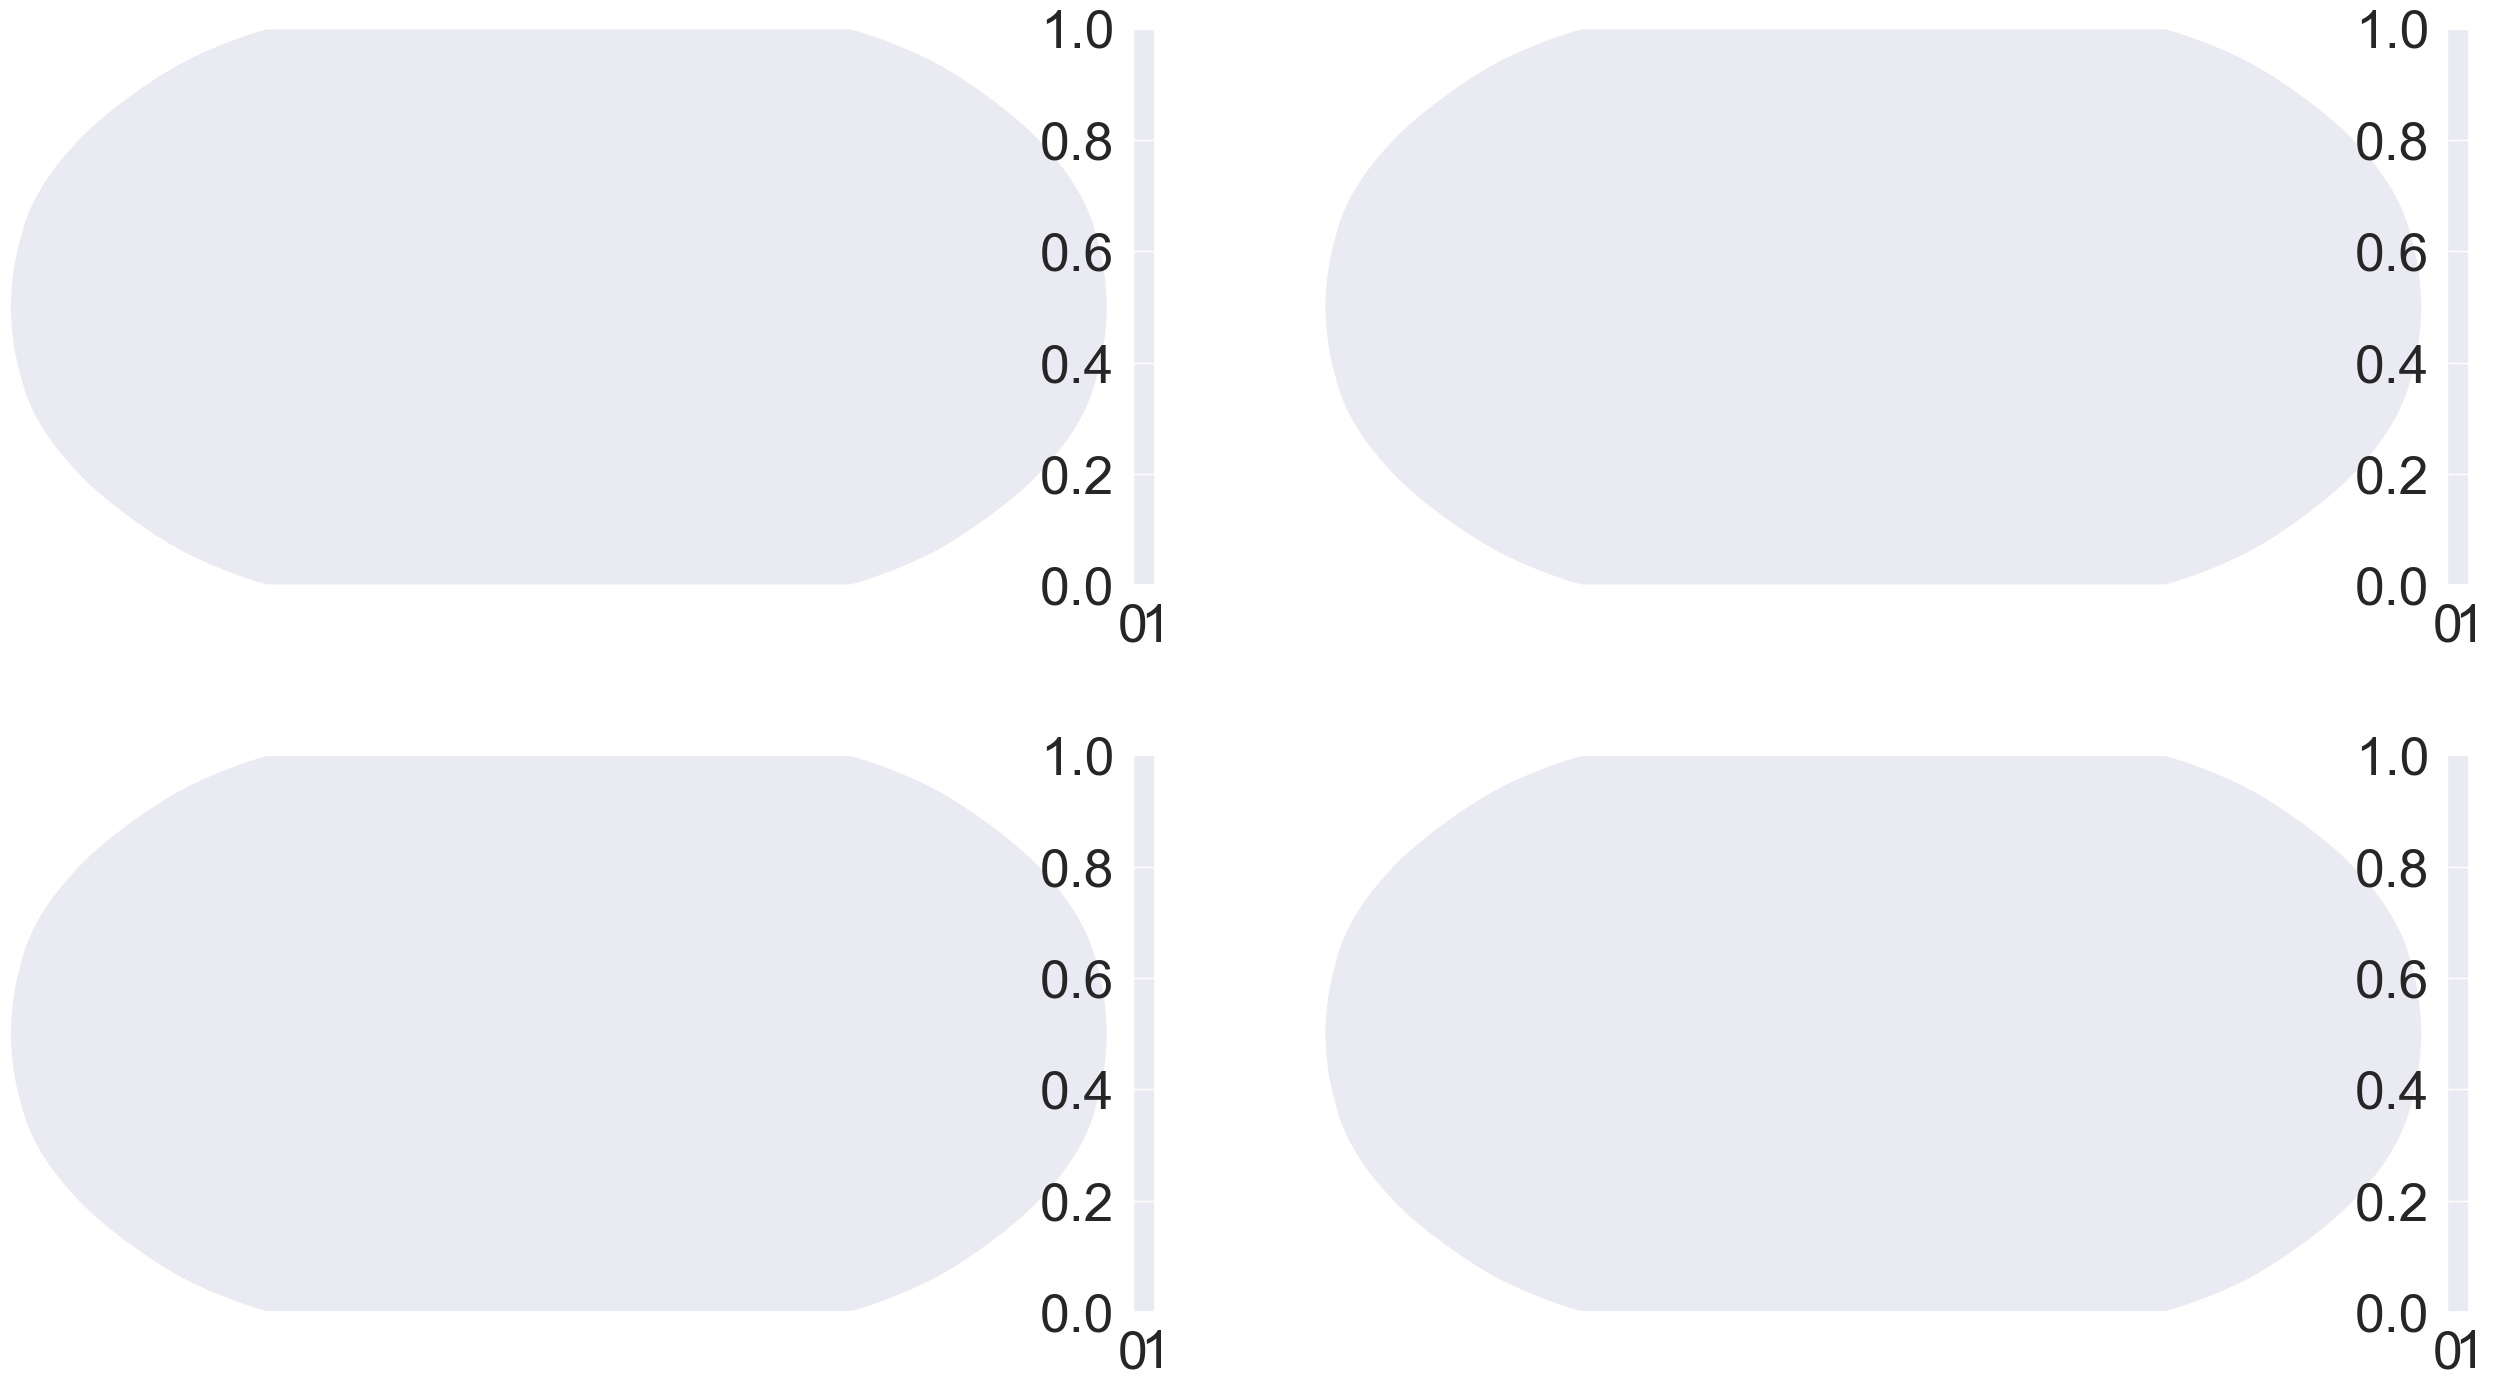

In [16]:
fig = plt.figure(figsize=(26,20), tight_layout=True)
axes_class = (GeoAxes, dict(projection=crt.crs.Robinson()))
axs = AxesGrid(fig, 111, axes_class=axes_class,
               nrows_ncols=(2, 2),
               share_all=True,
               axes_pad=1.7,
               cbar_location='right',
               cbar_mode='each',
               cbar_size='2%',
               cbar_pad=0.25,
               label_mode='keep') 

cm = sns.diverging_palette(150, 275, n=11).as_hex() # 11
cm[6] = '#D3D3D3'; cm[4] = '#D3D3D3'
cm = ListedColormap(cm)
clim=[-5.5,5.5]
label='No. of models showing decrease/increase'

axs[0].set_title("a) Intermodel agreement on sign of change for 1985-2014", size=20, loc='left')
xx, cb = global_map(axs[0], pxyn, no_models['current'], cm, clim, label)
cb.ax.set_yticks(np.arange(5, 5+1 , 1))
cb.ax.set_yticklabels(np.round(np.arange(np.arange(5, 5+1 , 1),0)))
cb.ax.tick_params(labelsize=12)

axs[1].set_title("b) Intermodel agreement on sign of change for 2021-2050", size=20, loc='left')
xx, cb = global_map(axs[1], pxyn, no_models['current'], cm, clim, label)
cb.ax.set_yticks(np.arange(5, 5+1 , 1))
cb.ax.set_yticklabels(np.round(np.arange(np.arange(5, 5+1 , 1),0)))
cb.ax.tick_params(labelsize=12)

clim=[0,0.25]
label='Standard deviation (m)'
cm = ListedColormap(sns.color_palette("rocket_r", 10).as_hex())    
axs[2].set_title('c) Model spread for 1985-2014', size=20,loc='left')
xx, cb = global_map(axs[2], pxyn, changes_current_stats['std'], cm, clim, label)
cb.ax.set_yticks(np.arange(clim[0],clim[1]+0.02,0.05))
cb.ax.set_yticklabels(np.round(np.arange(np.arange(5, 5+1 , 1),0)))
cb.ax.tick_params(labelsize=12)

axs[2].set_title('c) Model spread for 2021-2050', size=20,loc='left')
xx, cb = global_map(axs[2], pxyn, changes_future_stats['std'], cm, clim, label)
cb.ax.set_yticks(np.arange(clim[0],clim[1]+0.02,0.05))
cb.ax.set_yticklabels(np.round(np.arange(np.arange(5, 5+1 , 1),0)))
cb.ax.tick_params(labelsize=12)
                      
plt.show()